## Initialisation

In [68]:
import random
import time
import pprint

from matplotlib import pyplot as plt
from pymongo import MongoClient
import numpy as np


# Init
mongo = MongoClient('localhost', 27017)
db = mongo['citeos']
collection_villes = db['villes']
collection_routes = db['routes']
collection_clients = db['clients']

## Generation Villes & Routes

In [164]:
def generate_cities(n):
    collection_villes.drop()
    collection_routes.drop()

    cities = []
    roads = []

    #start = time.perf_counter()

    for i in range(1, n + 1):
        cities.append({"id_ville": i})
        for j in range(i - 1, -1, -1):
            if random.random() > 0.95: roads.append({"route": "route " + str(i) + "/" + str(j),"id_ville_1": i,"id_ville_2": j,"est_oriente": True,"poids_1": int(random.random() * 590 + 10),"poids_2": int(random.random() * 590 + 10),"trafic": [random.random() * 0.50 + 0.50 for _ in range(0, 24, 4)]})
            else: roads.append({"route": "route " + str(i) + "/" + str(j),"id_ville_1": i,"id_ville_2": j,"est_oriente": False,"poids": int(random.random() * 590 + 10),"trafic": [random.random() * 0.50 + 0.50 for _ in range(0, 24, 4)]})
        if len(roads) >= 1000:
            collection_routes.insert_many(roads)
            roads = []
    collection_villes.insert_many(cities)
    if roads: collection_routes.insert_many(roads)

    #print(time.perf_counter() - start)


generate_cities(1000)

## Generation Clients


In [165]:
def generate_clients(n):
    collection_clients.drop()
    clients = []

    for i in range(1, n + 1):
        client = {"id_client" : i, 'est_client': True}
        if random.random() > 0.5:
            randomizer = random.random()
            if randomizer < 0.33:
                client['type'] = 'particulier'
                clients.append(client)
            elif randomizer < 0.66:
                client['type'] = 'frais'
                clients.append(client)
            else:
                client['type'] = 'prisonnier'
                clients.append(client)
        else:
            client['est_client'] = False
            clients.append(client)
    collection_clients.insert_many(clients)

generate_clients(collection_villes.count_documents({}))


## Import Graphe

In [69]:
num_clients_FR = list(map(lambda x: x['id_client'], collection_clients.aggregate([{"$match" : {'est_client': True, 'type': 'frais'}}])))
num_clients_PA = list(map(lambda x: x['id_client'], collection_clients.aggregate([{"$match" : {'est_client': True, 'type': 'particulier'}}])))
num_clients_PR = list(map(lambda x: x['id_client'], collection_clients.aggregate([{"$match" : {'est_client': True, 'type': 'prisonnier'}}])))

num_clients_FR.append(0)
num_clients_PA.append(0)
num_clients_PR.append(0)

roads_FR = np.array(list(collection_routes.find({'id_ville_1': {'$in': num_clients_FR}, 'id_ville_2': {'$in': num_clients_FR}})))
roads_PA = np.array(list(collection_routes.find({'id_ville_1': {'$in': num_clients_PA}, 'id_ville_2': {'$in': num_clients_PA}})))
roads_PR = np.array(list(collection_routes.find({'id_ville_1': {'$in': num_clients_PR}, 'id_ville_2': {'$in': num_clients_PR}})))

num_clients_FR.remove(0)
num_clients_PA.remove(0)
num_clients_PR.remove(0)


## Fonction Voisin

In [3]:
def neighborhood(circuit):
    """
    Cette fonction est un generateur de tous les voisins valides d'une solution
    """
    for i in range (1, len(circuit) - 2):
        neighbor_circuit = circuit.copy()
        neighbor_circuit[i], neighbor_circuit[i + 1] = neighbor_circuit[i + 1], neighbor_circuit[i]
        yield neighbor_circuit

test_circuit = [0,2,18,20,32,37,0]
print(f'origine : {test_circuit}')
for n in neighborhood(test_circuit):
    print(f'voisin  : {n}')

origine : [0, 2, 18, 20, 32, 37, 0]
voisin  : [0, 18, 2, 20, 32, 37, 0]
voisin  : [0, 2, 20, 18, 32, 37, 0]
voisin  : [0, 2, 18, 32, 20, 37, 0]
voisin  : [0, 2, 18, 20, 37, 32, 0]


## Fonction Recuperation Routes

In [4]:
def import_roads(cities):
     return np.array(list(collection_routes.find({'id_ville_1': {'$in': cities}, 'id_ville_2': {'$in': cities}})))


## Fonction Score

In [5]:
def circuit_score(circuit, roads):
    """
    Cette fonction retourne le score d'un circuit eulerien, cela permettra de comparer les differents voisins entre eux
    """
    score = 0
    for i in range(0, len(circuit) - 1):
        #on recupere la bonne route
        road = next(item for item in roads if (item["id_ville_1"] == circuit[i] and item["id_ville_2"] == circuit[i + 1]) or (item["id_ville_1"] == circuit[i + 1] and item["id_ville_2"] == circuit[i]))
        #on verifie si la route est oriente ou non, si oui, on cherche le bon sens
        if road['est_oriente']: score += road['poids_1'] if road['id_ville_1'] == circuit[i] else road['poids_2']
        else: score += road['poids']
    return score

test_circuit = [0,2,18,20,32,37,0]
test_roads = import_roads(test_circuit)

for neighbor in neighborhood(test_circuit):
    print(circuit_score(neighbor, test_roads))

1616
1651
2037
1349


## Recherche Tabou

In [6]:
def tabu_search(initial_circuit, tabu_size, max_iteration, actual_roads):
    iteration = 1
    tabu_list = list()
    actual_circuit = initial_circuit.copy()

    best_actual_circuit = initial_circuit.copy()
    best_total_circuit = initial_circuit.copy()
    best_total_value = circuit_score(best_total_circuit, actual_roads)

    best_total_list = list()
    best_actual_list = list()

    while iteration <= max_iteration:
        iteration += 1
        best_actual_value = -1

        # on parcourt les voisins de la solution courante
        for neighbor in neighborhood(actual_circuit):
            if neighbor not in tabu_list and (circuit_score(neighbor, actual_roads) <= best_actual_value or best_actual_value == -1):
                best_actual_value = circuit_score(neighbor, actual_roads)
                best_actual_circuit = neighbor.copy()

        # on met a jour la meilleur solution rencontree depuis le debut
        if best_actual_value < best_total_value:
            best_total_circuit = best_actual_circuit.copy()
            best_total_value = best_actual_value

        best_total_list.append(best_total_value)
        best_actual_list.append(best_actual_value)

        actual_circuit = best_actual_circuit.copy()

        if len(tabu_list) >= tabu_size: tabu_list.pop(0)
        tabu_list.append(actual_circuit.copy())

    return best_total_circuit, best_total_list, best_actual_list


## Single-start

[0, 18, 2, 20, 37, 32, 44, 48, 70, 52, 0]


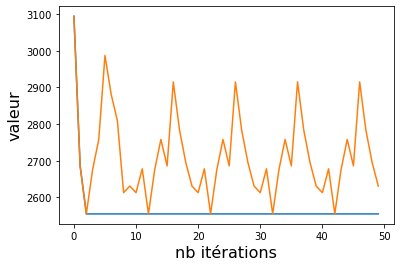

In [171]:
test_circuit = [0,2,18,20,32,37,44,48,52,70,0]


best_circuit, bt, ba= tabu_search(test_circuit, 9, 50)
plt.xlabel("nb itérations", fontsize=16)
plt.ylabel("valeur", fontsize=16)
print(best_circuit)
res = plt.plot(range(50), bt)
res = plt.plot(range(50), ba)

## Multi-start

[0, 52, 44, 18, 70, 20, 48, 2, 37, 32, 0]


<Figure size 1080x360 with 0 Axes>

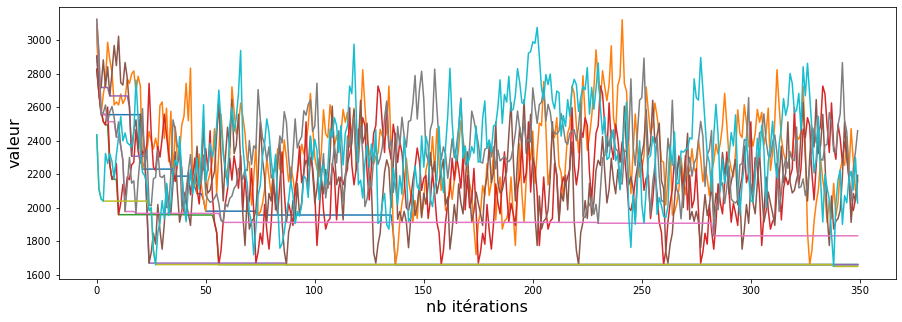

In [7]:
def tabu_multi_start(number, iteration, shuffled, actual_roads):
    plt.figure(figsize=(15,5))
    best_local_score = -1
    best_local_circuit = []
    for i in range(0, number):

        shuffled_circuit = shuffled.copy()
        shuffled_circuit.append(0)
        shuffled_circuit.insert(0, 0)
        bc, bt, ba= tabu_search(shuffled_circuit, 100, iteration, actual_roads)
        actual_score = circuit_score(bc, actual_roads)

        if best_local_score == -1 or actual_score < best_local_score:
            best_local_score = actual_score
            best_local_circuit = bc

        plt.xlabel("nb itérations", fontsize=16)
        plt.ylabel("valeur", fontsize=16)
        res = plt.plot(range(iteration), bt)
        res = plt.plot(range(iteration), ba)

        random.shuffle(shuffled)
    return best_local_circuit



n = 5
test_circuit = [0,2,18,20,32,37,44,48,52,70,0]
shuffled = test_circuit[1:-1]

it = 350

plt.figure(figsize=(15,5))
best = -1


roads = import_roads(test_circuit)

print(tabu_multi_start(n, it, test_circuit, roads))

## Graphe vers circuitS

In [152]:
k = 30

len(num_clients_FR)
#roads_FR

def create_circuits(clients_list, roads_list, k):
    total_of_clients = sum(len(client_list) for client_list in [num_clients_FR, num_clients_PA, num_clients_PR])
    number_of_clients = [len(client_list) for client_list in [num_clients_FR, num_clients_PA, num_clients_PR]]
    trucks_for_lists = [int(k * percentage) for percentage in [len(client_list) / total_of_clients for client_list in [num_clients_FR, num_clients_PA, num_clients_PR]]]
    while sum(trucks_for_lists) != k: trucks_for_lists[random.randint(0, len(trucks_for_lists) - 1)] += 1

    origins = [0,0,0]
    clients_per_k = [noc // tfl for noc, tfl in zip(number_of_clients, trucks_for_lists)]
    difference = [noc % cpk for noc, cpk in zip(number_of_clients, clients_per_k)]


    circuits = [[],[],[]]
    print(difference)
    print(trucks_for_lists)
    print(number_of_clients)
    print(clients_per_k)


    for idx, client_list in enumerate(clients_list):
        passed = [origins[idx],]
        actual_node = random.choice(client_list)
        for truck in range(0, trucks_for_lists[idx]):
            truck_circuit = []
            truck_circuit.append(actual_node)
            passed.append(actual_node)
            while len(truck_circuit) != clients_per_k[idx]:
                truck_circuit.append(get_closer_node(truck_circuit[-1], roads_list[idx], passed))
                passed.append(truck_circuit[-1])
            if difference[idx] > 0:
                difference[idx] -= 1
                truck_circuit.append(get_closer_node(truck_circuit[-1], roads_list[idx], passed))
                passed.append(truck_circuit[-1])
            actual_node = get_closer_node(truck_circuit[-1], roads_list[idx], passed)

            circuits[idx].append(truck_circuit)
    return circuits
circuits = create_circuits([num_clients_FR, num_clients_PA, num_clients_PR], [roads_FR, roads_PA, roads_PR], k)


print(c)

[7, 3, 3]
[8, 11, 11]
[135, 179, 179]
[16, 16, 16]
[[[471, 215, 714, 18, 71, 498, 120, 875, 41, 521, 74, 959, 240, 397, 48, 98, 110], [288, 77, 584, 621, 583, 693, 557, 256, 839, 845, 991, 692, 126, 958, 667, 965, 863], [294, 39, 616, 771, 286, 612, 443, 588, 435, 502, 136, 366, 386, 945, 200, 399, 85], [887, 579, 878, 99, 919, 503, 377, 104, 224, 365, 257, 271, 537, 848, 194, 530, 102], [283, 706, 760, 548, 501, 679, 111, 719, 9, 787, 886, 380, 191, 732, 949, 932, 24], [681, 160, 206, 334, 951, 943, 623, 196, 831, 225, 237, 64, 241, 964, 527, 321, 528], [292, 281, 885, 591, 749, 251, 308, 731, 280, 299, 81, 337, 759, 344, 922, 473, 371], [205, 805, 608, 615, 653, 658, 695, 725, 784, 794, 832, 855, 862, 876, 954, 994]], [[882, 10, 318, 828, 631, 511, 273, 222, 128, 465, 37, 410, 89, 341, 396, 182, 868], [127, 665, 476, 571, 956, 34, 328, 73, 697, 72, 114, 454, 398, 44, 599, 635, 620], [700, 322, 988, 540, 624, 186, 850, 353, 531, 291, 556, 253, 699, 499, 859, 167, 469], [419, 202, 710,

In [143]:
def get_closer_node(node, roads, passed):
    min_weight = -1
    next_node = 0
    for road in roads:
        if road['est_oriente']:
            if ((road['id_ville_1'] == node and min_weight > road['poids_1']) or (min_weight == -1 )) and road['id_ville_2'] not in passed:
                min_weight = road['poids_1']
                next_node = road['id_ville_2']
            elif ((road['id_ville_2'] == node and min_weight > road['poids_2']) or (min_weight == -1 )) and road['id_ville_1'] not in passed:
                min_weight = road['poids_2']
                next_node = road['id_ville_1']
        elif (min_weight > road['poids'] or  min_weight == -1) and (road['id_ville_1'] not in passed and road['id_ville_2'] not in passed) and (road["id_ville_1"] == node or road["id_ville_2"] == node):
            min_weight = road['poids']
            next_node = road['id_ville_1'] if road["id_ville_2"] == node else road['id_ville_2']

    return next_node
get_closer_node(0, roads_FR, [])

749

In [70]:
number_of_clients = sum(len(client_list) for client_list in [num_clients_FR, num_clients_PA, num_clients_PR])
clients_per_k = number_of_clients // k
difference = number_of_clients % (clients_per_k * k)

trucks_for_lists = [int(k * percentage) for percentage in [len(client_list) / number_of_clients for client_list in [num_clients_FR, num_clients_PA, num_clients_PR]]]
while sum(trucks_for_lists) != k: trucks_for_lists[random.randint(0, len(trucks_for_lists) - 1)] += 1


print(trucks_for_lists)

print(number_of_clients)
print(clients_per_k)
print(clients_per_k * k)
print(difference)


[9, 10, 11]
493
16
480
13


In [128]:
passed = [39, 18]
node = 48
print([r for r in roads_FR if ((r["id_ville_1"] == node or r["id_ville_2"] == node) and (r["id_ville_1"] not in passed or r["id_ville_2"] not in passed))])

[{'_id': ObjectId('60d1ced5b21851482ec4bebf'), 'route': 'route 48/41', 'id_ville_1': 48, 'id_ville_2': 41, 'est_oriente': False, 'poids': 544, 'trafic': [0.7299085004734496, 0.5089810471156524, 0.6340608860742529, 0.5022841024684582, 0.5631520290539835, 0.628679121561392]}, {'_id': ObjectId('60d1ced5b21851482ec4bec1'), 'route': 'route 48/39', 'id_ville_1': 48, 'id_ville_2': 39, 'est_oriente': False, 'poids': 43, 'trafic': [0.6486951675576362, 0.8271762152121254, 0.5440359370263255, 0.9814379755130018, 0.5985525877249596, 0.708981599868572]}, {'_id': ObjectId('60d1ced5b21851482ec4bed0'), 'route': 'route 48/24', 'id_ville_1': 48, 'id_ville_2': 24, 'est_oriente': False, 'poids': 285, 'trafic': [0.5314650418767582, 0.87200527195053, 0.6694350283121258, 0.5501156457386036, 0.9281699921246702, 0.8686053739431335]}, {'_id': ObjectId('60d1ced5b21851482ec4bed6'), 'route': 'route 48/18', 'id_ville_1': 48, 'id_ville_2': 18, 'est_oriente': False, 'poids': 455, 'trafic': [0.6157244559664388, 0.6222